# Assignment Day 5

## Team members:
- Samuel Nebgen s6sanebg@uni-bonn.de
- Muhammad Humza Arain s27marai@uni-bonn.de
- Julian Meigen s82jmeig@uni-bonn.de

## 12.09.2025

Contributions were made by all team members in around the same amount, either based on discussions or coding.

# Predicting Time-To-Event for a Breast Cancer Data Set

This notebook provides the tasks of predicting the time-to-event for a breast cancer dataset. The dataset is originally from [here](https://archive.ics.uci.edu/dataset/16/breast+cancer+wisconsin+prognostic), but a formatted version is available in the Github repository.

The dataset contains numerous patient characteristics and an indicator of whether or not the cancer has recurred. The task is to predict the time-to-event for the patients.

The main tasks are: 

- Load the dataset & explore the data
- Plot Kaplan-Meier survival curves
- Fit a Cox proportional hazards model
- Implement a DeepSurv model
- Compare model performance

## Task 1: Load the dataset & explore the data

The data set is available in the Github repository. Load the dataset and look at the features. You can look at some features and see if they are associated with recurrence or not.

In [2]:
available_columns = [
    "id",
    "outcome",
    "time",
    "radius_mean",
    "texture_mean",
    "perimeter_mean",
    "area_mean",
    "smoothness_mean",
    "compactness_mean",
    "concavity_mean",
    "concave_points_mean",
    "symmetry_mean",
    "fractal_dimension_mean",
    "radius_se",
    "texture_se",
    "perimeter_se",
    "area_se",
    "smoothness_se",
    "compactness_se",
    "concavity_se",
    "concave_points_se",
    "symmetry_se",
    "fractal_dimension_se",
    "radius_worst",
    "texture_worst",
    "perimeter_worst",
    "area_worst",
    "smoothness_worst",
    "compactness_worst",
    "concavity_worst",
    "concave_points_worst",
    "symmetry_worst",
    "fractal_dimension_worst",
    "tumor_size",
    "lymph_node_status",
]

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import lifelines

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os

### Load the Data

In [4]:
datafile = os.path.join("..", "data", "raw", "wpbc.data")
data = pd.read_csv(datafile, header=None, index_col=0, names=available_columns)

In [5]:
data.head()

,outcome,time,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,tumor_size,lymph_node_status
id,,,,,,,,,,,,,,,,,,,,,
119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,0.1086,0.07055,...,139.70,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5
8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.3001,0.14710,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2
842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,0.1255,0.08180,...,159.10,1949.0,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0
843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,0.10520,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0
843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,0.10430,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0


In [6]:
# Convert lymph_node_status to float, replacing "?" with NaN
data.lymph_node_status = data.lymph_node_status.where(data.lymph_node_status != "?", np.nan).astype("float")

### Explore the Data

#### Violin Plot for each feature grouped by outcome

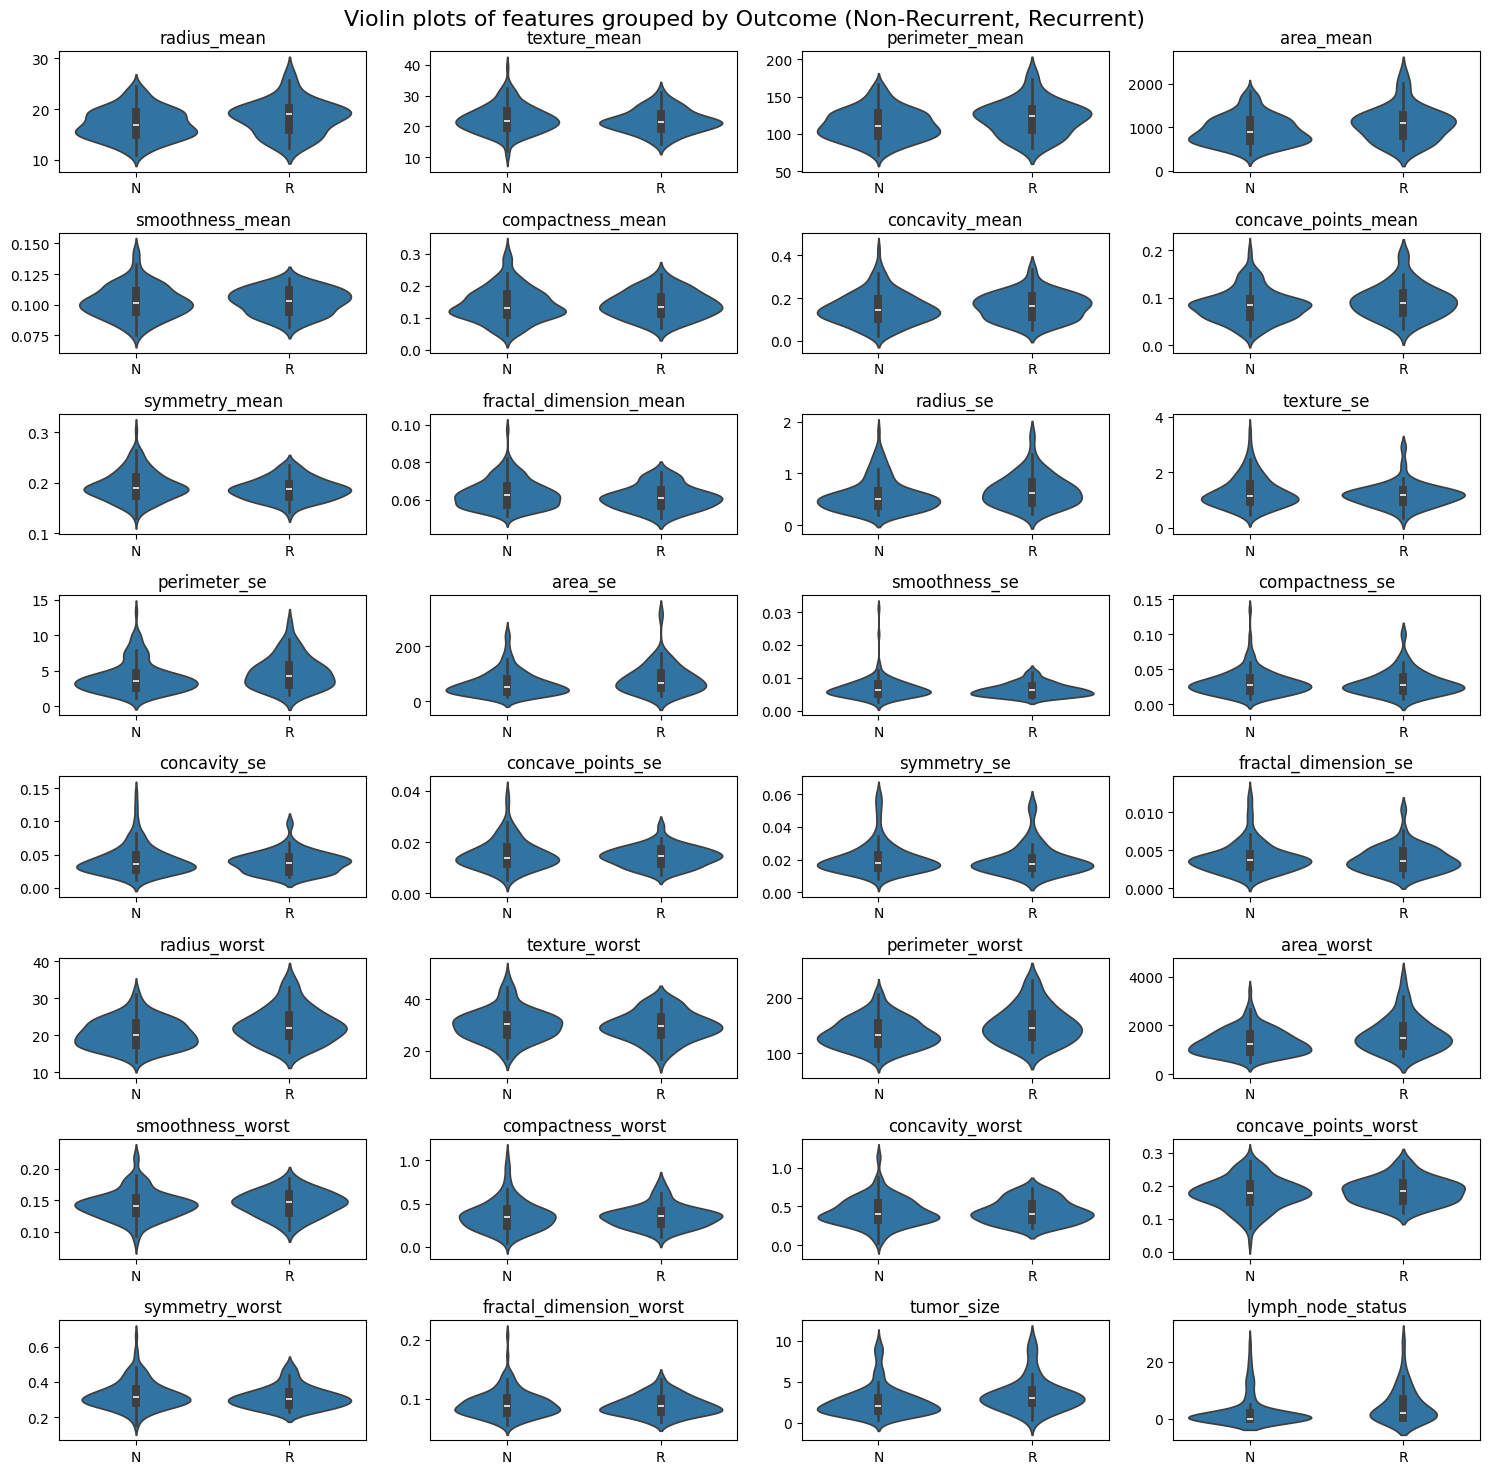

In [7]:
fig, axes = plt.subplots(8,4, figsize=(15,15))
for i, col in enumerate(data.columns[2:]):
    sns.violinplot(x=data["outcome"], y=data[col], ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(col)
    axes[i//4, i%4].set_xlabel("")
    axes[i//4, i%4].set_ylabel("")
fig.suptitle("Violin plots of features grouped by Outcome (Non-Recurrent, Recurrent)", fontsize=16)
plt.tight_layout()


By looking at the Distributions of each feature compared to the outcome, we can see clear differences between features, which could indicate that the features has an effect on the outcome.

Features with differ the mmost are: 
- radius_mean and radius_se
- perimeter_mean and parimeter_se
- area_mean and area_se
- tumor_size
- lymph_node_status

#### Statistical analysis

In [8]:
# now doing the mann whitney u test
from scipy.stats import mannwhitneyu
significant_vars = []
for col in data.columns[2:]:
    group1 = data[data["outcome"] == 'N'][col]
    group2 = data[data["outcome"] == 'R'][col]
    stat, p = mannwhitneyu(group1, group2)
    if p < 0.05:
        significant_vars.append(col)
        print(f"{col}: U-statistic={stat}, p-value={p}")



radius_mean: U-statistic=2760.5, p-value=0.02170323266364902
perimeter_mean: U-statistic=2745.5, p-value=0.01932307306603115
area_mean: U-statistic=2714.0, p-value=0.015055171976655577
radius_se: U-statistic=2770.0, p-value=0.023340805922652166
perimeter_se: U-statistic=2775.0, p-value=0.02424410856576506
area_se: U-statistic=2717.5, p-value=0.015484556253994426
radius_worst: U-statistic=2552.5, p-value=0.0037099504859011362
perimeter_worst: U-statistic=2585.0, p-value=0.0049991788397547735
area_worst: U-statistic=2550.5, p-value=0.0036416630895414926
tumor_size: U-statistic=2392.0, p-value=0.0007260946657710445


In [9]:
from scipy.stats import ttest_ind

significant_vars_ttest = []
for col in data.columns[2:]:
    group1 = data[data["outcome"] == 'N'][col]
    group2 = data[data["outcome"] == 'R'][col]
    stat, p = ttest_ind(group1, group2)
    if p < 0.05:
        significant_vars_ttest.append(col)
        print(f"{col}: t-statistic={stat}, p-value={p}")

radius_mean: t-statistic=-2.4755494025176885, p-value=0.014151431734283742
perimeter_mean: t-statistic=-2.51020989392295, p-value=0.012874839955837375
area_mean: t-statistic=-2.707764835446465, p-value=0.007372496899567576
perimeter_se: t-statistic=-2.0030571162370077, p-value=0.0465488453798921
area_se: t-statistic=-2.1504929524772716, p-value=0.03274080823224723
radius_worst: t-statistic=-3.3577489371112406, p-value=0.0009439852805053054
perimeter_worst: t-statistic=-3.33907981513205, p-value=0.001006064853118334
area_worst: t-statistic=-3.3895094039039533, p-value=0.0008465204467802073
tumor_size: t-statistic=-2.52176731709643, p-value=0.012472583774605105


Based on t-test and Mann-Whitney U test, the following features show significant differences between the two outcome groups N and R:
- radius_mean
- perimeter_mean
- area_mean
- perimeter_se
- area_se
- radius_worst
- perimeter_worst
- area_worst
- tumor_size

## Task 2: Generate Kaplan-Meier Survival Curves

Kaplan-Meier survival curves are a good way to visualize survival data. Generate the Kaplan-Meier survival curves for the data set. You can use the `lifelines' library for this task.

You should generate the survival curves for the following characteristics

- Tumor size (greater or less than the median)
- Number of lymph nodes (0, <5, >=5)
- Recurrence-free survival (RFS)

You can also generate the survival curves for the features you consider important.

### Tumor Sizes

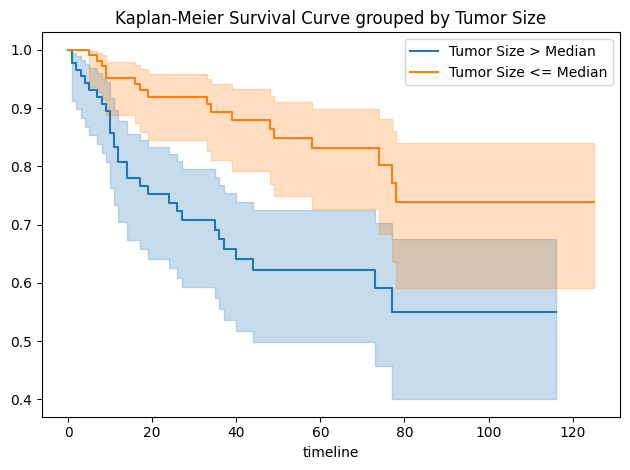

In [10]:
# Splitting Data based on median tumor size
mask_tumor_size_median = data["tumor_size"] > data["tumor_size"].median()

T = data["time"]
# Since E must be a boolean array, we convert the outcome to boolean
E = data["outcome"] == 'R'  # Event occurred if outcome is 'R': If True, Recurrent, If False, Non-Recurrent

# Plotting the Kaplan-Meier survival curves
kmf = lifelines.KaplanMeierFitter()
kmf.fit(T[mask_tumor_size_median], event_observed=E[mask_tumor_size_median])
kmf.plot_survival_function(label="Tumor Size > Median")


kmf.fit(T[~mask_tumor_size_median], event_observed=E[~mask_tumor_size_median])
kmf.plot_survival_function(label="Tumor Size <= Median")
plt.title("Kaplan-Meier Survival Curve grouped by Tumor Size")
plt.legend()
plt.tight_layout()
plt.show()

### Number of Lymphnodes states

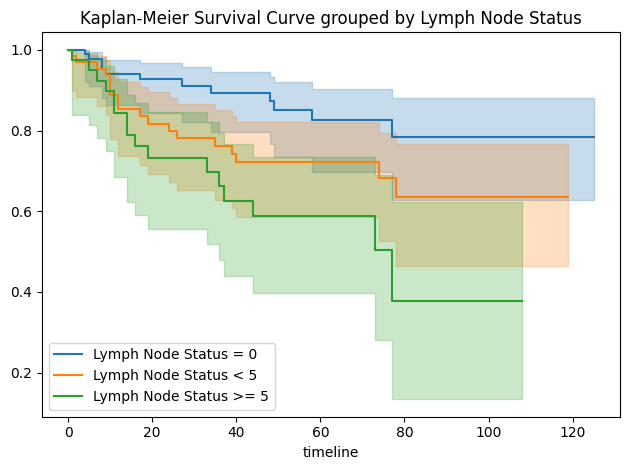

In [11]:
# Splitting Data based on lymph node status
mask_lymph_0 = data["lymph_node_status"] == 0
mask_lymph_smaller_5 = (data["lymph_node_status"] < 5 ) & (data["lymph_node_status"] > 0)
mask_lymph_bigger_equal_5 = data["lymph_node_status"] >= 5

T = data["time"]
# Since E must be a boolean array, we convert the outcome to boolean
E = data["outcome"] == 'R'  # Event occurred if outcome is 'R': If True, Recurrent, If False, Non-Recurrent

# Plotting the Kaplan-Meier survival curves
kmf = lifelines.KaplanMeierFitter()
kmf.fit(T[mask_lymph_0], event_observed=E[mask_lymph_0])
kmf.plot_survival_function(label="Lymph Node Status = 0")

kmf.fit(T[mask_lymph_smaller_5], event_observed=E[mask_lymph_smaller_5])
kmf.plot_survival_function(label="Lymph Node Status < 5")

kmf.fit(T[mask_lymph_bigger_equal_5], event_observed=E[mask_lymph_bigger_equal_5])
kmf.plot_survival_function(label="Lymph Node Status >= 5")
plt.title("Kaplan-Meier Survival Curve grouped by Lymph Node Status")
plt.legend()
plt.tight_layout()
plt.show()

### Reccurence-free Survival

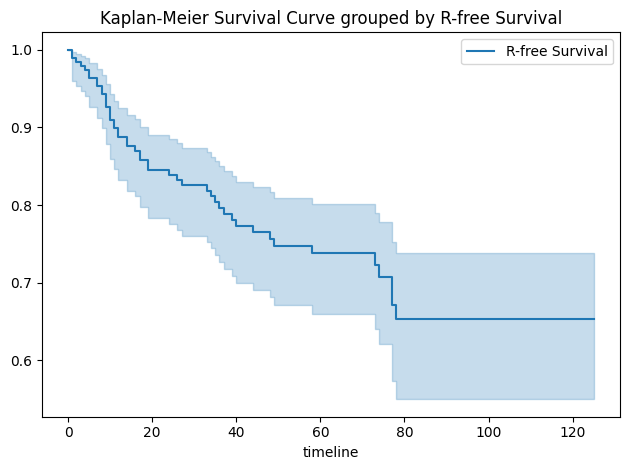

In [12]:
# Splitting Data based on R-free Survival

T = data["time"]
# Since E must be a boolean array, we convert the outcome to boolean
E = data["outcome"] == 'R'  # Event occurred if outcome is 'R': If True, Recurrent, If False, Non-Recurrent

# Plotting the Kaplan-Meier survival curves
kmf = lifelines.KaplanMeierFitter()
kmf.fit(T, event_observed=E)
kmf.plot_survival_function(label="R-free Survival")
plt.title("Kaplan-Meier Survival Curve grouped by R-free Survival")
plt.legend()
plt.tight_layout()
plt.show()

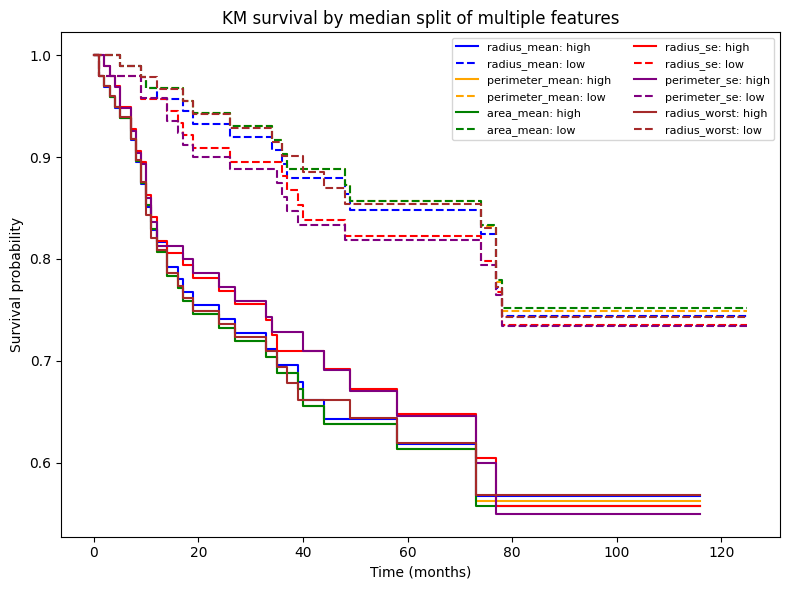

In [16]:
# for the other important features:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

features = {
    "radius_mean": data["radius_mean"],
    "perimeter_mean": data["perimeter_mean"],
    "area_mean": data["area_mean"],
    "radius_se": data["radius_se"],
    "perimeter_se": data["perimeter_se"],
    "radius_worst": data["radius_worst"],
}

color_list = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

fig, ax = plt.subplots(figsize=(8, 6))

for i, fname_s in enumerate(features.items()):
    fname, s = fname_s
    # ensure no NaNs in subsets
    med = s.median()
    hi = (s > med) & s.notna()
    lo = (s <= med) & s.notna()

    kmf.fit(T[hi], E[hi], label=f"{fname}: high")
    kmf.plot_survival_function(ax=ax, ci_show=False, color = color_list[i])        # solid

    kmf.fit(T[lo], E[lo], label=f"{fname}: low")
    kmf.plot_survival_function(ax=ax, ci_show=False, ls="--", color = color_list[i])  # dashed

ax.set_title("KM survival by median split of multiple features")
ax.set_xlabel("Time (months)")
ax.set_ylabel("Survival probability")
ax.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()





## Task 3: Fit a Cox Proportional Hazards model

The Cox Proportional Hazards model is a popular model for predicting time-to-event. Fit a Cox Proportional Hazards model to the data set. You can use the `lifelines' library for this task.

You should perform cross-validation to evaluate the performance of the model. You can use the C-index as an evaluation metric. See the documentation of the `lifelines' library to see how to perform a cross-validation. Finally, generate a boxplot of the C-index values.

In [ ]:
data["outcome"] = data["outcome"].map({'N': 0, 'R': 1})
data.dropna(inplace=True)
data_red = data.drop(columns=['fractal_dimension_mean', 'smoothness_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se']) # Drop since they give warnings 

coxph = lifelines.CoxPHFitter()
scores = lifelines.utils.k_fold_cross_validation(coxph, data, duration_col='time', event_col='outcome', scoring_method="concordance_index", k=5)

coxph.print_summary()

/Users/julianmeigen/miniconda3/envs/mlhandson/lib/python3.12/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['fractal_dimension_mean', 'smoothness_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/julianmeigen/miniconda3/envs/mlhandson/lib/python3.12/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/Users/julianmeigen/miniconda3/envs/mlhandson/lib/python3.12/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarni

<lifelines.CoxPHFitter: fitted with 156 total observations, 119 right-censored observations>
             duration col = 'time'
                event col = 'outcome'
      baseline estimation = breslow
   number of observations = 156
number of events observed = 37
   partial log-likelihood = -161.53
         time fit was run = 2025-09-12 11:20:52 UTC

---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                 
radius_mean              -0.66      0.52      2.17           -4.91            3.59                0.01               36.21
texture_mean             -0.00      1.00      0.13           -0.25            0.25                0.78                1.29
perimeter_mean            0.07      1.07      0.34           -0.60            0.74                0.55                2.09
area_mean                 0.00      1.00      0.01           -0.01            0.02                0.99                1.02
smoothness_mean          10.65  42030.06     49.12          -85.63          106.92                0.00            2.73e+46
compactness_mean          1.13      3.10     21.91          -41.82           44.08                0.00            1.39e+19
concavity_mean           -1.68      0.19     15.86          -32.75           29.40                0.00            5.88e+12
concave_points_mean       0.34      1.40     32.51          -63.37           64.05                0.00            6.57e+27
symmetry_mean            -3.25      0.04     15.16          -32.96           26.45                0.00            3.08e+11
fractal_dimension_mean  -30.49      0.00     99.40         -225.31          164.33                0.00            2.33e+71
radius_se                -0.08      0.92      6.10          -12.04           11.88                0.00            1.44e+05
texture_se               -0.11      0.90      0.81           -1.70            1.48                0.18                4.40
perimeter_se              0.04      1.04      0.77           -1.48            1.55                0.23                4.71
area_se                  -0.00      1.00      0.03           -0.05            0.05                0.95                1.06
smoothness_se           -10.62      0.00    155.72         -315.82          294.59                0.00           8.65e+127
compactness_se            1.07      2.93     53.38         -103.56          105.71                0.00            8.08e+45
concavity_se             -3.72      0.02     47.74          -97.28           89.85                0.00            1.05e+39
concave_points_se       -10.49      0.00     97.07         -200.74          179.77                0.00            1.18e+78
symmetry_se               7.64   2070.67     47.20          -84.87          100.15                0.00            3.11e+43
fractal_dimension_se     73.04  5.25e+31    436.11         -781.72          927.80                0.00                 inf
radius_worst              0.08      1.08      0.81           -1.52            1.67                0.22                5.31
texture_worst             0.00      1.00      0.12           -0.23            0.23                0.80                1.26
perimeter_worst          -0.00      1.00      0.08           -0.17            0.16                0.85                1.18
area_worst               -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
smoothness_worst         -0.09      0.92     24.28          -47.67           47.50                0.00            4.26e+20
compactness_worst        -0.55      0.58      6.83          -13.94           12.84                0.00            3.77e+05
concavity_worst           0.62      1.85      5.32           -9.82           11.05                0.00            62901.81
concave_points_worst      0.24      1.27     12.46          -24.18         

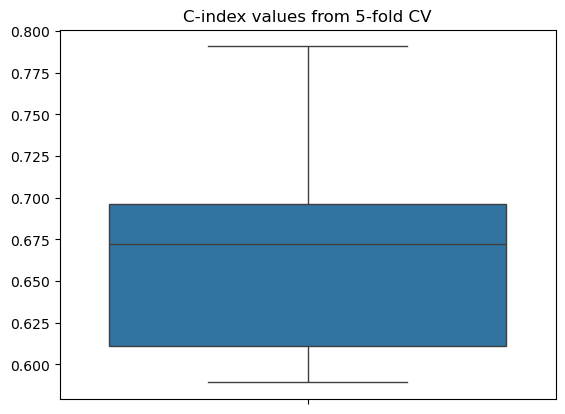

In [ ]:
sns.boxplot(scores)
plt.title("C-index values from 5-fold CV")
plt.show()

## Task 4: Implement a DeepSurv model

DeepSurv is a deep learning model for time-to-event prediction. Implement this model, evaluate its performance using cross-validation, and generate a box plot of the C-index values.

1. First, you need to create an appropriate **Dataset** class that returns the features, the time-to-event, and the event indicator.
2. Then you need a neural network model that takes the features as input and returns the predicted hazard ratio.
3. You need to implement a training and evaluation loop for the model. As a loss function, you can use the `neg_partial_log_likelihood` from the `torchsurv` library.
4. You need to put everything together and run a cross-validation to evaluate the performance of the model. Evaluate the performance in each fold using the C-index.

Notes: 
- Remember to scale the features before feeding them into the model.
- Do not optimize the hyperparameters of the model. In this case, you would need to implement nested cross-validation, which is beyond the scope of this notebook. You can use a learning rate of 0.01 and 50 epochs for training. If your model does not perform well, try using two linear layers of 32 units each and a ReLU activation function. The final output dimension should be 1.

### Data Preparation

In [ ]:
class SurvivalDataSet(Dataset):
    def __init__(self, data, feature_col=None, time_col='time', event_col='outcome'):
        if feature_col is None:
            self.data = torch.tensor(data.drop(columns=[time_col, event_col]).values, dtype=torch.float32)
        else:
            self.data = torch.tensor(data[feature_col].values, dtype=torch.float32)
        self.T = torch.tensor(data[time_col].values, dtype=torch.float32)
        self.E = torch.tensor(data[event_col].values, dtype=torch.int)

    def __len__(self):
        return len(self.T)

    def __getitem__(self, idx):
        return self.data[idx], self.T[idx], self.E[idx]


#### Split and Normalize

In [ ]:
def split_normalize_data(data, random_state=None):
    # Split
    train_data_raw, test_data_raw = train_test_split(data, test_size=0.2, stratify=data['outcome'], random_state=random_state)
    # Normalize
    scaler = MinMaxScaler()
    train_dataset_scaled_data = scaler.fit_transform(train_data_raw.drop(columns=['time', 'outcome']))
    test_dataset_scaled_data = scaler.transform(test_data_raw.drop(columns=['time', 'outcome']))
    # Create Dataset objects (first convert numpy array to dataframe again and than convert to Dataset)
    train_dataset_scaled_df = pd.DataFrame(train_dataset_scaled_data, columns=data.columns.drop(['time', 'outcome']))
    train_dataset_scaled_df['time'] = train_data_raw['time'].values
    train_dataset_scaled_df['outcome'] = train_data_raw['outcome'].values

    test_dataset_scaled_df = pd.DataFrame(test_dataset_scaled_data, columns=data.columns.drop(['time', 'outcome']))
    test_dataset_scaled_df['time'] = test_data_raw['time'].values
    test_dataset_scaled_df['outcome'] = test_data_raw['outcome'].values

    train_dataset = SurvivalDataSet(train_dataset_scaled_df)
    test_dataset = SurvivalDataSet(test_dataset_scaled_df)
    # Dataloader
    train_data_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
    test_data_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

    return train_dataset, test_dataset, train_data_loader, test_data_loader

In [ ]:
train_dataset, test_dataset, train_data_loader, test_data_loader = split_normalize_data(data_red, random_state=42)

### DeepSurv Model

In [ ]:
class DeepSurv(nn.Module):
    def __init__(self, input_dim):
        super(DeepSurv, self).__init__()
        self.deepsurv_net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        return self.deepsurv_net(x)

### Train

In [ ]:
train_dataset.data.shape[1]

27

In [ ]:
model = DeepSurv(input_dim=train_dataset.data.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def one_fold_train_and_eval(train_data_loader, val_data_loader, model, optimizer):
    EPOCHS = 50
    #training_losses = []
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for x, t, e in train_data_loader:
            optimizer.zero_grad()
            loss = neg_partial_log_likelihood(model(x), e, t)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        #total_loss /= len(train_data_loader.dataset)
        #training_losses.append(total_loss)
    

    # Eval with C-index
    model.eval()
    with torch.no_grad():
        for x, t, e in val_data_loader:
            pred_hazard_ratio = model(x)
            c_index = lifelines.utils.concordance_index(t, -pred_hazard_ratio, e)
            
    return c_index


In [ ]:
def train_with_cv(data, k=5):
    c_indices = []
    for fold in range(k):
        # Split and normalize data
        train_dataset, test_dataset, train_data_loader, test_data_loader = split_normalize_data(data)
        # Initialize model and optimizer
        model = DeepSurv(input_dim=train_dataset.data.shape[1])
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        # Train and evaluate
        c_index = one_fold_train_and_eval(train_data_loader, test_data_loader, model, optimizer)
        c_indices.append(c_index)
    return c_indices

In [ ]:
c_scores = train_with_cv(data_red, k=10)

/Users/julianmeigen/miniconda3/envs/mlhandson/lib/python3.12/site-packages/torchsurv/loss/cox.py:222: UserWarning: Ties in event time detected; using efron's method to handle ties.
  warnings.warn(
/Users/julianmeigen/miniconda3/envs/mlhandson/lib/python3.12/site-packages/torchsurv/loss/cox.py:222: UserWarning: Ties in event time detected; using efron's method to handle ties.
  warnings.warn(
/Users/julianmeigen/miniconda3/envs/mlhandson/lib/python3.12/site-packages/torchsurv/loss/cox.py:222: UserWarning: Ties in event time detected; using efron's method to handle ties.
  warnings.warn(
/Users/julianmeigen/miniconda3/envs/mlhandson/lib/python3.12/site-packages/torchsurv/loss/cox.py:222: UserWarning: Ties in event time detected; using efron's method to handle ties.
  warnings.warn(
/Users/julianmeigen/miniconda3/envs/mlhandson/lib/python3.12/site-packages/torchsurv/loss/cox.py:222: UserWarning: Ties in event time detected; using efron's method to handle ties.
  warnings.warn(
/Users/jul

<Axes: >

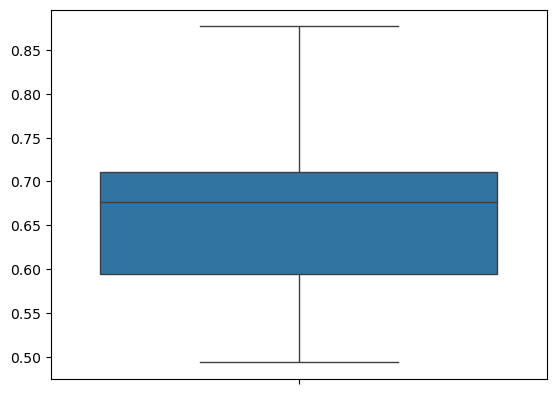

In [ ]:
sns.boxplot(c_scores)

## Task 5: Describe your results



## Optional

- Add a feature selection method to the Cox Proportional Hazards model.
- Attempt to implement nested cross-validation to optimize the hyperparameters of the DeepSurv model.